--- 1. Setting up Environment ---
Tue Oct 28 20:44:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]


Total images in DataLoader (Estimated): 50000

--- Verification: Inspecting a sample batch ---
Clean Image Batch Shape: torch.Size([16, 3, 64, 64])
Mask Batch Shape: torch.Size([16, 3, 64, 64])
Masked Image Batch Shape: torch.Size([16, 3, 64, 64])


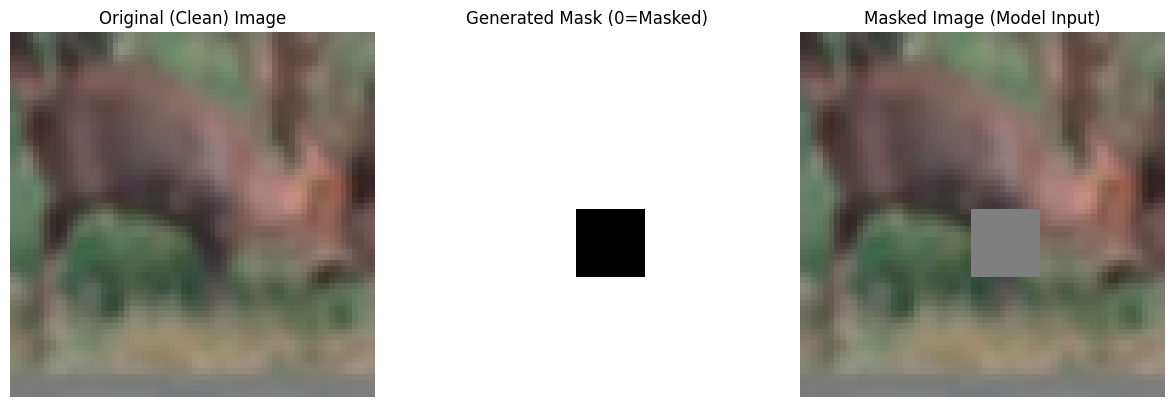


--- Week 2 Pipeline Complete and Verified. ---


In [1]:
#################################################################
# Cell 1: Environment Setup
# (Fulfills: "Set up the development environment (Python, PyTorch/TensorFlow, necessary libraries like diffusers)")
#################################################################
print("--- 1. Setting up Environment ---")
!nvidia-smi
!pip install -qq torch torchvision torchaudio Pillow
!pip install -qq datasets transformers accelerate diffusers matplotlib

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print("\n--- Setup complete. Libraries loaded. ---")


#################################################################
# Cell 2: Data Acquisition, Pre-processing, and Mask Logic
# (Fulfills: "Acquire, clean, and pre-process" and "Implement the mask generation logic")
#################################################################
print("\n--- 2. Defining Data Pipeline ---")

# --- CONFIGURATION ---
DATASET_NAME = "cifar10" # A small, public dataset for demonstration
IMAGE_SIZE = 64 # Resize all images to 64x64 for fast local testing
BATCH_SIZE = 16
MAX_MASK_FRACTION = 0.35 # Max size of the square mask (e.g., 35% of the image side)
# ---------------------

class InpaintingDataset(Dataset):
    """
    This class handles:
    1. Data Acquisition (from Hugging Face)
    2. Data Pre-processing (Resize, Normalize)
    3. Mask Generation (Random Square)
    """
    def __init__(self, dataset_name, image_size):
        # 1. Acquire the chosen dataset
        print(f"Loading dataset: {dataset_name}...")
        self.data = load_dataset(dataset_name, split="train")

        # 2. Define Pre-processing Transforms
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(), # Convert PIL Image to Tensor (C, H, W)
            T.Normalize([0.5], [0.5]) # Normalize to [-1, 1] range
        ])

        self.image_size = image_size
        self.max_mask_length = int(image_size * MAX_MASK_FRACTION)

    def __len__(self):
        return len(self.data)

    def generate_random_square_mask(self):
        """
        Implements the mask generation logic: creates a random square mask.
        The mask is a tensor of 0s (masked/inpainted) and 1s (kept).
        """
        # Start with a mask of ones (keeping all pixels)
        mask = torch.ones(1, self.image_size, self.image_size)

        # Determine random size of the square mask
        mask_len = random.randint(self.max_mask_length // 4, self.max_mask_length)

        # Determine random starting position (top-left corner)
        max_start = self.image_size - mask_len
        start_x = random.randint(0, max_start)
        start_y = random.randint(0, max_start)

        # Apply the mask: set the area to 0
        mask[:, start_y:start_y + mask_len, start_x:start_x + mask_len] = 0.0

        return mask.repeat(3, 1, 1) # Repeat for 3 color channels (C, H, W)


    def __getitem__(self, idx):
        # Load the image from the dataset object and convert to RGB
        original_image_pil = self.data[idx]['img'].convert("RGB")

        # Apply pre-processing (Resize, ToTensor, Normalize)
        clean_image = self.transform(original_image_pil)

        # Generate the mask (3 channels, 64x64)
        mask = self.generate_random_square_mask()

        # Create the masked image (image * mask), which is the input to the model
        masked_image = clean_image * mask

        dummy_text = "a photo"

        return {
            "clean_image": clean_image,
            "mask": mask,
            "masked_image": masked_image,
            "text": dummy_text
        }

print("--- Data Pipeline Defined. ---")


#################################################################
# Cell 3: Execution and Verification
# (This step runs the code to prove the setup is complete)
#################################################################
print("\n--- 3. Running and Verifying Pipeline ---")

# Create Dataset and DataLoader
inpainting_dataset = InpaintingDataset(dataset_name=DATASET_NAME, image_size=IMAGE_SIZE)

train_dataloader = DataLoader(
    inpainting_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

print(f"\nTotal images in DataLoader (Estimated): {len(train_dataloader) * BATCH_SIZE}")

# --- Verification: Inspect a sample batch ---
print("\n--- Verification: Inspecting a sample batch ---")
sample_batch = next(iter(train_dataloader))

print(f"Clean Image Batch Shape: {sample_batch['clean_image'].shape}")
print(f"Mask Batch Shape: {sample_batch['mask'].shape}")
print(f"Masked Image Batch Shape: {sample_batch['masked_image'].shape}")

# --- Visualization ---

# Helper function to convert normalized tensor back to plottable image
def denormalize_and_reformat(tensor):
    # Denormalize from [-1, 1] back to [0, 1] and move C from 0 to 2 (C, H, W) -> (H, W, C)
    return (tensor.numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)

# Get the first sample from the batch
img = sample_batch['clean_image'][0]
masked_img = sample_batch['masked_image'][0]
mask = sample_batch['mask'][0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original (Clean) Image")
plt.imshow(denormalize_and_reformat(img))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated Mask (0=Masked)")
plt.imshow(mask[0], cmap='gray') # Show just one channel for the mask
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Masked Image (Model Input)")
plt.imshow(denormalize_and_reformat(masked_img))
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Week 2 Pipeline Complete and Verified. ---")